# Code to pull terminus positions from the manual delineations exported from GEEDiT

_By Jukes Liu. last modified 11-10-2019._

## Set up:

In [825]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math
from PIL import Image
import scipy.misc

import shutil

#geospatial packages
import fiona
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import shapely
#shapely to explore 2D spatial relationships (e.g. intersection of 2 vector files)

basepath = '/media/jukes/jukes1/Manual/EarthEngine/'

In [874]:
#Read in glacier velocity data
flowspeed_df= pd.read_csv('/home/jukes/Documents/Sample_glaciers/Glacier_vel_measures_sample10.csv', sep=',', dtype=str)
# flowspeed_df= pd.read_csv('/home/jukes/Documents/Sample_glaciers/Glacier_velocities.csv', sep=',', dtype=str, usecols=[1,2,3])
flowspeed_df = flowspeed_df.set_index('BoxID')

Functions:

In [827]:
#define a function to help us find the intersection of a line and a collection of points:
#determines if an input value is within a certain range/interval or a setvalue:
def within(value, setval, interval):
    if value >= setval-interval and value <= setval+interval:
        return True
    else:
        return False

In [828]:
def distance(x1, y1, x2, y2):
    dist = math.sqrt(((x2-x1)**2)+((y2-y1)**2))
    return dist

In [904]:
def to_datetimes(df):
    datetimes = df.loc[:,'datetimes']
    datetime_objs = []
    for date in datetimes:
        datetime_obj = datetime.datetime.strptime(str(date), '%Y-%m-%d')
        datetime_obj = np.datetime64(datetime_obj)
        datetime_objs.append(datetime_obj)
    df['datetimes'] = datetime_objs
    return df

## 1) Reproject manual delineation shapefiles into Greenland Polar Stereo and grab BoxIDs

For different versions of delineations of the same image, pick the most recent one (2) instead of (1) or the original.

In [3]:
# counter = 0
# taggedimgs = []
# tagged2 = []
# BoxIDs = []

# for file in os.listdir(basepath):
#     if '(' in file and file not in taggedimgs:
#         taggedimgs.append(file.split('(')[0])

# for file in os.listdir(basepath):
#     for img in taggedimgs: 
#         if file.startswith(img) and '(' not in file:
#             #remove the images without parentheses
#             if file in os.listdir(basepath):
#                 os.remove(basepath+file)
#         if file.startswith(img) and '(2)' in file:
#             tagged2.append(file.split('(')[0])
# tagged2 = set(tagged2)

# for file in os.listdir(basepath):
#     for img in tagged2: 
#         if file.startswith(img) and '(1)' in file:
#             os.remove(basepath+file)
#             print(file)

Reproject into Greenland Polar Stereo:

In [202]:
counter = 0
BoxIDs = []

for folder in os.listdir(basepath):
    BoxIDs.append(folder[3:])
    
    for file in os.listdir(basepath+folder):
        if file.endswith('.shp'):
#             #pull BoxID from name of file
#             BoxID = '%03d' % int(file.split('_')[0][3:])

            #reproject the file from lat, long to Greenland Polar Stereo
            linepath = basepath+folder+'/'+file[:-4]
            rp_command = 'ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:3413 -s_srs EPSG:4326 '+linepath+'_PS.shp '+linepath+'.shp'
#             print(rp_command)
            subprocess.call(rp_command, shell=True)

            #keep track of how many shapefiles there are
            counter = counter + 1
        
print(counter)
BoxIDs = list(set(BoxIDs))
print(BoxIDs)

1610
['002', '001', '259', '120', '174']


Split into their own box folders:

In [8]:
# #make results directory in BoxID folder if it doesn't already exist
# for BoxID in BoxIDs:
#     if os.path.exists(basepath+"Box"+BoxID):
#         print("Already exists.")
#         #OTHERWISE, create the folder and download into it
#     else:
#         os.mkdir(basepath+"Box"+BoxID)
#         print("Folder made for Box"+BoxID)

In [7]:
# #move em!
# for BoxID in BoxIDs:
#     box = '%01d' % int(BoxID)
#     for file in os.listdir(basepath):
#         if file.startswith('Box'+box) and len(file)>6:
#             shutil.move(basepath+file, basepath+'Box'+BoxID+'/'+file)
#             print(file+' moved')

## 2) Rasterize the shapefiles and subset to the buffer zones

In [203]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    for file in os.listdir(basepath+folder):
#       print(file)
        if file.endswith('PS.shp'):
            linepath = basepath+folder+'/'+file[:-4]
            rasterize_cmd = 'gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 '+linepath+'.shp '+linepath+'.TIF'
#             print(rasterize_cmd)
            
            subprocess.call(rasterize_cmd, shell=True)

In [204]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    for file in os.listdir(basepath+folder):
#       print(file)
        if file.endswith('PS.shp'):
            linepath = basepath+folder+'/'+file[:-4]
            buffer_path = "/home/jukes/Documents/Sample_glaciers/Box"+BoxID+"/Buffer"+BoxID+".shp"
            
            subsetbuffer_cmd = 'gdalwarp -cutline '+buffer_path+' -crop_to_cutline '+linepath+'.TIF'+" "+linepath+'_cut.TIF'
#             print(subsetbuffer_cmd)
            subprocess.call(subsetbuffer_cmd, shell=True)
    
            #ADD SOMETHING TO CONVERT TO PNG

## 3) Rotate the rasterized & subset delineations

Convert images to png files

In [834]:
# %%bash

# cd /media/jukes/jukes1/Manual/EarthEngine/Box174/
# mogrify -format png *cut.TIF

In [872]:
flowspeed_df

,Flow_dir,Max_speed
BoxID,,
001,56.28428268432617,0.043774381279945374
002,155.9872283935547,3.583226442337036
004,-3.483433723449707,0.6230824589729309
033,142.1181640625,0.7716577649116516
120,-77.38639831542969,0.27788856625556946
174,12.677642822265625,0.9145031571388245
235,-145.85076904296875,0.15709678828716278
259,98.99927520751953,3.0749008655548096
277,-65.12018585205078,0.28601959347724915


Make rotated folders and rotate

In [208]:
#make results directory in BoxID folder if it doesn't already exist
for BoxID in BoxIDs:
    if os.path.exists(basepath+"Box"+BoxID+'/rotated/'):
        print("Already exists.")
        #OTHERWISE, create the folder and download into it
    else:
        os.mkdir(basepath+"Box"+BoxID+'/rotated/')
        print("Folder made for Box"+BoxID)

Already exists.
Already exists.
Already exists.
Already exists.
Already exists.


In [873]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    for file in os.listdir(basepath+folder):
#         print(file)
        if file.endswith('PS_cut.png') and len(file) == 50:
            img  = Image.open(basepath+folder+'/'+file)
            #rotate the image by the flow direction from flowspeed_df
            rotated     = img.rotate(-float(flowspeed_df.loc[BoxID, 'Flow_dir']))
            rotated.save(basepath+folder+'/rotated/R_'+file)
#             print(file)
#             print(flowspeed_df.loc['001', 'Flow_dir'])

## 4) Resize all images to minimum image dimensions

Move terminus box rasters to the folder:

In [837]:
for BoxID in BoxIDs:
    pathtotbox = '/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated/R_Box'+BoxID+'_raster_cut.png'
    shutil.copy(pathtotbox, basepath+'Box'+BoxID+'/rotated/R_Box'+BoxID+'_raster_cut.png')

Grab image dimensions from automated image rotations and crop all to the minimum

In [829]:
basepath

'/media/jukes/jukes1/Manual/EarthEngine/'

In [877]:
for BoxID in BoxIDs:
    images = os.listdir('/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated/')
    for image in images:
        if image.endswith('.png'):
            imagetest = mpimg.imread('/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated/'+image)
            #grab image dimensions
            min_y=imagetest.shape[0]; min_x = imagetest.shape[1]
    print(BoxID, min_x, min_y)
            
    for image in os.listdir(basepath+'Box'+BoxID+'/rotated/'):
        if image.startswith('R_crop_Box'):
            os.remove(basepath+'Box'+BoxID+'/rotated/'+image)
    for image in os.listdir(basepath+'Box'+BoxID+'/rotated/'):
        if image.endswith('.png'):
            #crop each image if the dimensions are larger than the minimum
            img = mpimg.imread(basepath+'Box'+BoxID+'/rotated/'+image)
            rows = img.shape[0]; columns = img.shape[1]
            #calculate difference, and divide by 2 to get amount of rows to remove by
            diffx_half = (columns - min_x)/2; diffy_half = (rows - min_y)/2 
            
            if diffx_half > 0 or diffy_half > 0:
                #if the difference is a half pixel, make sure to remove the full value from the first side only
                if int(diffx_half) != diffx_half:
                    #remember for image slicing y is number of rows, x is the number of columns
                    img_cropx = img[:, int(diffx_half):-int(diffx_half)-1]
                #otherwise remove it from both sides:
                else:
                    img_cropx = img[:, int(diffx_half):-int(diffx_half)]
                
                #same for y
                if int(diffy_half) != diffy_half:   
                    img_cropy = img_cropx[int(diffy_half):-int(diffy_half)-1, :]
                #otherwise remove it from both sides:
                else:
                    img_cropy = img_cropx[int(diffy_half):-int(diffy_half), :]
                    
                #save over rotated images with new cropped dimensions:
                scipy.misc.imsave(basepath+'Box'+BoxID+'/rotated/'+image, img_cropy)
            
            #add 0s if image dimensions are smaller than the min! (001)
            elif diffx_half < 0 or diffy_half < 0:
                #columns (x):
                diffx_half = abs(diffx_half); diffy_half = abs(diffy_half)
                #if the difference is a half pixel, add the full one to end
                if int(diffx_half) != diffx_half and int(diffx_half) != 0:
                    img_addx1 = np.column_stack((np.zeros((rows, int(diffx_half))), img))
                    img_addx2 = np.column_stack((img_addx1, np.zeros((rows, int(diffx_half)+1))))
                #if it's a whole pixel, add to cols to beginning and end
                else:
                    img_addx1 = np.column_stack((np.zeros((rows, int(diffx_half))), img))
                    img_addx2 = np.column_stack((img_addx1, np.zeros((rows, int(diffx_half)))))
                #rows(y):
                if int(diffy_half) != diffy_half:
                    img_addy1 = np.vstack((np.zeros((int(diffy_half), img_addx2.shape[1])), img_addx2))
                    img_addy2 = np.vstack((img_addy1, np.zeros((int(diffy_half)+1, img_addx2.shape[1]))))
                else:
                    img_addy1 = np.vstack((np.zeros((int(diffy_half), img_addx2.shape[1])), img_addx2))
                    img_addy2 = np.vstack((img_addy1, np.zeros((int(diffy_half), img_addx2.shape[1]))))
                
                #save over rotated images with new cropped dimensions:
                scipy.misc.imsave(basepath+'Box'+BoxID+'/rotated/'+image, img_addy2)

002 1222 1161
001 307 322


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


259 798 1017


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


120 295 302
174 658 650


## 5) Read in rasterized delineations and grab pixel coordinates

In [878]:
IDs = []; line_xs = []; line_ys = []; dates = []

for BoxID in BoxIDs:
    for file in os.listdir(basepath+'Box'+BoxID+'/rotated/'):
        if file.startswith('R') and file.endswith('PS_cut.png'):
            #pull date from name of file
            date = file.split('_')[5][:10]
#             print(date)

            linepath = basepath+'Box'+BoxID+'/rotated/'+file; line = cv2.imread(linepath)
#             print(line.shape)
            
            if len(line.shape) > 2:
#                 print(line)
                y, x, rgb = np.where(line > 0)

                line_x = []; line_y = []
                for i in range(0, len(y)):
                    x0 = x[i]; y0 = y[i]; rgb0 = rgb[i]

                    if rgb0 == 0:
#                         print(x0, y0, rgb0)
                        line_x.append(x0); line_y.append(y0)

                IDs.append(BoxID); dates.append(date); line_xs.append(line_x); line_ys.append(line_y)

manual_df = pd.DataFrame(list(zip(IDs, dates, line_xs, line_ys)),
              columns=['BoxID','datetimes', 'Line_x', "Line_y"])
manual_df = manual_df.sort_values(by=['BoxID', 'datetimes'])
manual_df

,BoxID,datetimes,Line_x,Line_y
186,001,2013-05-05,"[135, 134, 135, 133, 133, 132, 134, 134, 135, ...","[141, 142, 142, 143, 144, 145, 146, 147, 147, ..."
269,001,2013-05-14,"[131, 132, 133, 133, 134, 135, 136, 136, 137, ...","[144, 145, 146, 147, 148, 149, 149, 150, 150, ..."
184,001,2013-05-29,"[132, 132, 132, 134, 134, 136, 136, 137, 139, ...","[143, 144, 145, 146, 147, 147, 148, 149, 150, ..."
254,001,2013-08-23,"[133, 132, 133, 131, 132, 131, 130, 131, 131, ...","[142, 143, 143, 144, 144, 145, 146, 147, 148, ..."
266,001,2013-08-27,"[130, 129, 130, 129, 130, 131, 132, 133, 133, ...","[144, 145, 145, 148, 149, 149, 149, 150, 151, ..."
238,001,2013-09-03,"[128, 129, 129, 130, 131, 131, 132, 134, 134, ...","[141, 142, 143, 143, 143, 144, 145, 146, 147, ..."
279,001,2013-09-10,"[131, 132, 130, 131, 129, 130, 129, 129, 130, ...","[140, 141, 142, 142, 143, 143, 144, 146, 147, ..."
203,001,2013-09-17,"[130, 129, 130, 128, 129, 128, 129, 129, 130, ...","[142, 144, 144, 145, 146, 147, 147, 148, 148, ..."
236,001,2013-09-19,"[130, 131, 129, 130, 129, 128, 129, 129, 130, ...","[142, 142, 144, 144, 146, 147, 147, 148, 149, ..."
239,001,2013-09-26,"[129, 128, 129, 128, 129, 130, 130, 131, 132, ...","[144, 146, 146, 147, 147, 147, 148, 149, 149, ..."


## Manual delineations gif Box001

In [268]:
# #Turn datetimes from datetime_df into DateTime objects
# to_datetimes(manual_df)

In [265]:
# manual_df.to_csv(path_or_buf = basepath+"Manual_imgdates.csv", sep=',')

In [267]:
# #PLOT THE LANDSAT IMAGE and TERMINUS BOX
# BoxID = '001'
# box_df = manual_df[manual_df.BoxID == BoxID].copy()
# # box_df = box_df[box_df.Date > np.datetime64('2013-01-01')].copy()

# #Read in the non_rotated subset image:
# # image = mpimg.imread('/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated/crop_manual/R_LC80310052014178LGN00_B8_PS_Buffer'+BoxID+'.png')
# tbox = mpimg.imread("/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated/crop_manual/Box"+BoxID+"_raster_cut.png")

# plt.figure(figsize=(20,10))
# plt.axis("off")
# imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# boxplt = plt.imshow(tbox, alpha=0.1)

# counter = 0
# for idx, row in box_df.iterrows():
#     if idx % 7 == 0:
#         counter = counter + 1
        
# colors = pl.cm.viridis(np.linspace(0,1,counter))

# col_count = 0
# for idx, row in box_df.iterrows():
#     if idx % 7 == 0:
#         #     BoxID = idx
#         line_x = row['Line_x']
#         line_y = row['Line_y']

#         plt.plot(line_x, line_y, color=colors[col_count], linewidth=0.5)
#         col_count = col_count+1
        
# #grab x-values from height of terminus box
# c_slope = float(centerline_df.loc[BoxID]['cline_slope'])
# c_intercept = float(centerline_df.loc[BoxID]['cline_intercept'])
# xmin = float(centerline_df.loc[BoxID]['midpoint_x'])
# xmax = np.max(np.array(list(set(np.nonzero(tbox)[1]))))

# c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)
# c_y = c_slope*c_x + c_intercept
# plt.plot(c_x, c_y, color='gray')
# plt.plot(c_x[0], c_y[0], 'co')

# plt.show()


## 5) Calculate interesections with centerline and terminus position

Read in 3 centerlines (25, 50, 75)

In [880]:
# pathrows_df = pd.read_csv(basepath+'LS_pathrows_multiple.csv', sep=',', usecols =[0,1,2], dtype=str)
centerline_df = pd.read_csv('/home/jukes/Documents/Sample_glaciers/Boxes_coords_pathrows.csv', sep=',',dtype=str)
centerline_df = centerline_df.set_index('BoxID')
# centerline_df

In [967]:
intersection_x = []; intersection_y = []
ix_25 = []; iy_25 = []; ix_75 = []; iy_75 = []
term_pos50 = []; tpos25 = []; tpos75 = []

prev_BoxID = 'anything'

for idx, row in manual_df.iterrows():
#     print(str(row['datetimes'])[:10])
#     if str(row['datetimes'])[:10] == '2014-08-14' and row['BoxID'] == '002':
        line_x = row['Line_x']; line_y = row['Line_y']
        
        if row['BoxID'] != prev_BoxID:
            #don't duplicate efforts in calculating a new centerline
            BoxID = row['BoxID']

            #grab slope and intercepts from the dataframe
            c_slope = float(centerline_df.loc[BoxID]['m50'])
            c_intercept = float(centerline_df.loc[BoxID]['b50'])
            m25 = float(centerline_df.loc[BoxID]['m25']); b25 = float(centerline_df.loc[BoxID]['b25'])
            m75 = float(centerline_df.loc[BoxID]['m75']); b75 = float(centerline_df.loc[BoxID]['b75'])

            #grab x-values from height of terminus box
            ymid = float(centerline_df.loc[BoxID]['lmid50_y']); xmid = float(centerline_df.loc[BoxID]['lmid50_x'])
            xmax = float(centerline_df.loc[BoxID]['rmid50_x'])
            ymid25 = float(centerline_df.loc[BoxID]['lmid25_y']); xmid25 = float(centerline_df.loc[BoxID]['lmid25_x'])
            xmax25 = float(centerline_df.loc[BoxID]['rmid25_x'])
            ymid75 = float(centerline_df.loc[BoxID]['lmid75_y']); xmid75 = float(centerline_df.loc[BoxID]['lmid75_x'])
            xmax75 = float(centerline_df.loc[BoxID]['rmid75_x'])
            
            #calculate centerlines:
            cx50 = np.linspace(xmid, xmax, int(xmax-xmid)*10); cy50 = c_slope*cx50 + c_intercept
            cx25 = np.linspace(xmid25, xmax25, int(xmax25-xmid25)*10); cy25 = m25*cx25 + b25
            cx75 = np.linspace(xmid75, xmax75, int(xmax75-xmid75)*10); cy75 = m75*cx75 + b75

        #FIND Intersections   
        intersect_xs = []; intersect_ys = []; intersect_xs25 = []; intersect_ys25 = []; intersect_xs75 = []; intersect_ys75 = []

        #loop through all the x,y values for the delineation:
        for j in range(0, len(line_x)):
            lx = line_x[j]; ly = line_y[j]
            interval = 1.0
            #find intersections with each centerline:
            for i in range(0, len(cx50)):
                if within(lx, cx50[i], interval) and within (ly, cy50[i], interval):
                    intersect_xs.append(lx); intersect_ys.append(ly)
            for k in range(0, len(cx25)):
                if within(lx, cx25[k], interval) and within (ly, cy25[k], interval):
                    intersect_xs25.append(lx); intersect_ys25.append(ly)
            for l in range(0, len(cx75)):
                if within(lx, cx75[l], interval) and within (ly, cy75[l], interval):
                    intersect_xs75.append(lx); intersect_ys75.append(ly)

        #if there are intersections, calculate the terminus positions:
        if len(intersect_xs) != 0 or len(intersect_ys) != 0:
                #this was too slow, just use min
#             intersect_x = np.min(intersect_xs)
#             intersect_y = intersect_ys[intersect_xs.index(intersect_x)]
            intersect_x = intersect_xs[0]; intersect_y = intersect_ys[0]
            print(BoxID, row['datetimes'], intersect_x, intersect_y)
            intersection_x.append(intersect_x); intersection_y.append(intersect_y)
            #calculate terminus position using distance formula
#             term_position = distance(xmid, ymid, intersect_x, intersect_y)
            term_position = intersect_x-xmid
            term_pos50.append(term_position*15.0)
        #otherwise, append nans
        else:
            intersection_x.append(np.nan); intersection_y.append(np.nan); term_pos50.append(np.nan)  
            
        if len(intersect_xs25) != 0 or len(intersect_ys25) != 0:
            ix25 = intersect_xs25[0]; iy25 = intersect_ys25[0]
#             print(BoxID, row['datetimes'], ix25, iy25, "L25")
            ix_25.append(ix25); iy_25.append(iy25)
            #calculate terminus position using distance formula
#             term_position25 = distance(xmid25, ymid25, ix25, iy25)
            term_position25 = ix25-xmid25
            tpos25.append(term_position25*15.0)
        #otherwise, append nans
        else:
            ix_25.append(np.nan); iy_25.append(np.nan); tpos25.append(np.nan)  
        
        if len(intersect_xs75) != 0 or len(intersect_ys75) != 0:
            ix75 = intersect_xs75[0] ;iy75 = intersect_ys75[0]
#             print(BoxID, row['datetimes'], ix75, iy75, "L75")
            ix_75.append(ix75); iy_75.append(iy75)
            #calculate terminus position using distance formula
#             term_position75 = distance(xmid75, ymid75, ix75, iy75)
            term_position75 = ix75-xmid75
            tpos75.append(term_position75*15.0)
        #otherwise, append nans
        else:
#             print(BoxID, row['datetimes'], "nan, L75")
            ix_75.append(np.nan); iy_75.append(np.nan); tpos75.append(np.nan)
            
        prev_BoxID = BoxID
        
manual_df['intersect_x'] = intersection_x; manual_df['intersect_y'] = intersection_y
manual_df['tpos50'] = term_pos50; manual_df['tpos25'] = tpos25; manual_df['tpos75'] = tpos75
manual_df = manual_df.dropna()
manual_df

001 2013-05-05 00:00:00 142 159
001 2013-05-14 00:00:00 142 159
001 2013-05-29 00:00:00 144 159
001 2013-08-23 00:00:00 140 159
001 2013-08-27 00:00:00 140 159
001 2013-09-03 00:00:00 141 158
001 2013-09-10 00:00:00 139 158
001 2013-09-19 00:00:00 138 158
001 2013-09-26 00:00:00 137 158
001 2014-03-14 00:00:00 139 158
001 2014-03-19 00:00:00 141 159
001 2014-03-23 00:00:00 141 158
001 2014-03-28 00:00:00 141 158
001 2014-04-08 00:00:00 141 158
001 2014-04-13 00:00:00 141 158
001 2014-05-06 00:00:00 141 158
001 2014-05-22 00:00:00 141 159
001 2014-05-24 00:00:00 141 158
001 2014-05-26 00:00:00 141 159
001 2014-06-02 00:00:00 142 159
001 2014-06-09 00:00:00 142 159
001 2014-06-09 00:00:00 142 159
001 2014-06-25 00:00:00 141 158
001 2014-06-30 00:00:00 144 159
001 2014-07-04 00:00:00 141 158
001 2014-07-09 00:00:00 141 159
001 2014-07-11 00:00:00 143 159
001 2014-07-20 00:00:00 141 159
001 2014-07-27 00:00:00 142 159
001 2014-08-12 00:00:00 141 159
001 2014-08-14 00:00:00 141 159
001 2014

002 2016-07-07 00:00:00 662 575
002 2016-07-14 00:00:00 665 575
002 2016-07-16 00:00:00 666 575
002 2016-07-23 00:00:00 670 574
002 2016-07-30 00:00:00 652 576
002 2016-08-08 00:00:00 652 577
002 2016-08-10 00:00:00 652 576
002 2016-08-15 00:00:00 651 576
002 2016-08-24 00:00:00 649 576
002 2016-09-11 00:00:00 654 576
002 2016-09-13 00:00:00 654 576
002 2016-09-18 00:00:00 656 576
002 2016-09-29 00:00:00 652 576
002 2016-10-02 00:00:00 654 576
002 2016-10-02 00:00:00 653 576
002 2016-10-06 00:00:00 652 576
002 2017-03-13 00:00:00 657 576
002 2017-03-15 00:00:00 657 576
002 2017-03-20 00:00:00 664 575
002 2017-03-22 00:00:00 659 575
002 2017-03-24 00:00:00 659 575
002 2017-03-27 00:00:00 658 575
002 2017-03-31 00:00:00 662 575
002 2017-04-05 00:00:00 659 575
002 2017-04-09 00:00:00 659 575
002 2017-04-12 00:00:00 664 575
002 2017-04-14 00:00:00 661 575
002 2017-04-21 00:00:00 667 575
002 2017-04-25 00:00:00 666 575
002 2017-04-28 00:00:00 667 575
002 2017-04-30 00:00:00 662 575
002 2017

/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,BoxID,datetimes,Line_x,Line_y,intersect_x,intersect_y,tpos50,tpos25,tpos75
186,001,2013-05-05,"[135, 134, 135, 133, 133, 132, 134, 134, 135, ...","[141, 142, 142, 143, 144, 145, 146, 147, 147, ...",142,159,390.0,270.0,465.0
269,001,2013-05-14,"[131, 132, 133, 133, 134, 135, 136, 136, 137, ...","[144, 145, 146, 147, 148, 149, 149, 150, 150, ...",142,159,390.0,240.0,450.0
184,001,2013-05-29,"[132, 132, 132, 134, 134, 136, 136, 137, 139, ...","[143, 144, 145, 146, 147, 147, 148, 149, 150, ...",144,159,420.0,285.0,480.0
254,001,2013-08-23,"[133, 132, 133, 131, 132, 131, 130, 131, 131, ...","[142, 143, 143, 144, 144, 145, 146, 147, 148, ...",140,159,360.0,210.0,465.0
266,001,2013-08-27,"[130, 129, 130, 129, 130, 131, 132, 133, 133, ...","[144, 145, 145, 148, 149, 149, 149, 150, 151, ...",140,159,360.0,180.0,435.0
238,001,2013-09-03,"[128, 129, 129, 130, 131, 131, 132, 134, 134, ...","[141, 142, 143, 143, 143, 144, 145, 146, 147, ...",141,158,375.0,270.0,465.0
279,001,2013-09-10,"[131, 132, 130, 131, 129, 130, 129, 129, 130, ...","[140, 141, 142, 142, 143, 143, 144, 146, 147, ...",139,158,345.0,195.0,450.0
236,001,2013-09-19,"[130, 131, 129, 130, 129, 128, 129, 129, 130, ...","[142, 142, 144, 144, 146, 147, 147, 148, 149, ...",138,158,330.0,165.0,420.0
239,001,2013-09-26,"[129, 128, 129, 128, 129, 130, 130, 131, 132, ...","[144, 146, 146, 147, 147, 147, 148, 149, 149, ...",137,158,315.0,165.0,420.0
195,001,2014-03-14,"[130, 131, 131, 133, 133, 134, 134, 135, 136, ...","[146, 147, 148, 148, 149, 149, 150, 150, 151, ...",139,158,345.0,210.0,435.0


In [968]:
manual_df.to_csv(path_or_buf='/media/jukes/jukes1/Manual/manual_tpos.csv', sep=',')

## Analyze interanalyst variability:

In [882]:
#Read in duplicate delineations
# duplicate_df = pd.read_csv('/media/jukes/jukes1/Manual/LS8_manual_auto_Jan2020_2analysts.csv', usecols=[0,1,2],
#                            sep=',')
# duplicate_df = duplicate_df.set_index('BoxID')
# duplicate_df.head(10)

In [883]:
# manual_df

In [884]:
# differences = []; diffs25 = []; diffs75 = []

# for idx, row in duplicate_df.iterrows():
#     #grab the BoxID and date of duplicate delineation
#     BoxID = '%03d' % int(idx)
#     date = str(row['Date'])
# #     print(len(date))
#     if True == True:
# #     if date == '2014-08-14':
#         df_1 = manual_df[manual_df['BoxID']==BoxID].copy()
#     #     print(len(df_1))
#         df_2 = df_1[df_1['datetimes']==date].copy()
# #         print(df_2)

#         #grab the terminus position values from duplicates in manual_df
#         if len(list(df_2['tpos50'])) > 1:
#             x50_1, x50_2 = list(df_2['tpos50'])
#             diff50 = abs(x50_2-x50_1)
#             differences.append(diff50)
#         else:
#             differences.append(np.NaN)
#         if len(list(df_2['tpos25'])) > 1:
#             x25_1, x25_2 = list(df_2['tpos25'])
#             diff25 = abs(x25_2-x25_1)
#             diffs25.append(diff25)
#         else:
#             diffs25.append(np.NaN)
#         if len(list(df_2['tpos75'])) > 1:
#             x75_1, x75_2 = list(df_2['tpos75'])
#             diff75 = abs(x75_2-x75_1)
#             diffs75.append(diff75)
#         else:
#             diffs75.append(np.NaN)

# duplicate_df['diff50'] = differences
# duplicate_df['diff25'] = diffs25
# duplicate_df['diff75'] = diffs75

In [885]:
# comparisons = list(duplicate_df['diff75'])
# cleanedList = [x for x in comparisons if str(x) != 'nan']

# print("Max difference: "+str(np.max(cleanedList))+' meters')
# print("Average difference: "+str(np.average(cleanedList))+' meters')
# print("Median difference: "+str(np.median(cleanedList))+' meters')

### Result: inter-analyst variability

- Maximum difference = __~105 meters__ or __7 pixels__
- Average difference = __~20 meters__ or __1.3 pixels__

## 6) Plot manual terminus position time series

In [906]:
#Turn datetimes from datetime_df into DateTime objects
# to_datetimes(manual_df)

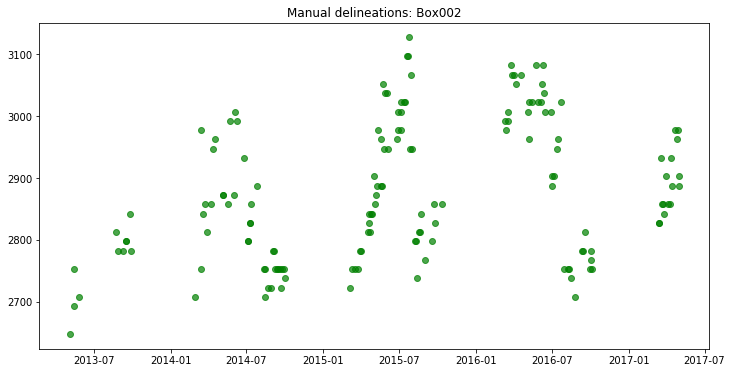

In [1000]:
BOI = '002'

df = manual_df[manual_df['BoxID']==BOI].copy()
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df['datetimes'], df['tpos50'], 'go', markersize='6', alpha=0.7)
plt.title('Manual delineations: Box'+BOI)
plt.show()

## 7) Plot automated vs. manual time series and analyze difference

In [1001]:
#Read in automated df
auto_df = pd.read_csv('/home/jukes/Documents/Sample_glaciers/Tpos_timeseries_Box'+BOI+'_filtered.csv', sep=',')

#Turn datetimes from datetime_df into DateTime objects
to_datetimes(auto_df)

,Unnamed: 0,Scene,BoxID,Image_array,Dat_filename,Trimmed_dat_filename,Scale,datetimes,Metric,Order,tpos,changerate,X
0,0,LC80340052013148LGN00,2,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_034.dat,terminus_trim_034.dat,34,2013-05-28,2.930000e-08,1,4027.5,NaN,"[737.0, 569.0]"
1,1,LC80310052013239LGN00,2,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2013-08-27,9.468827e+02,1,2917.5,-12.197802,"[663.0, 576.0]"
2,2,LC80330052013253LGN00,2,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2013-09-10,4.004018e+03,1,2977.5,4.285714,"[667.0, 575.0]"
3,3,LC80340052013260LGN00,2,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2013-09-17,1.572945e+03,1,2992.5,2.142857,"[668.0, 575.0]"
4,4,LC80330052013269LGN00,2,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2013-09-26,1.227284e+03,1,2947.5,-5.000000,"[665.0, 576.0]"
5,5,LC80310052013271LGN00,2,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2013-09-28,1.411248e+03,1,2962.5,7.500000,"[666.0, 576.0]"
6,6,LC80320052014073LGN00,2,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_005.dat,terminus_trim_005.dat,5,2014-03-14,1.431479e+01,2,2152.5,-4.850299,"[612.0, 580.0]"
7,7,LC80330052014144LGN00,2,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_022.dat,terminus_trim_022.dat,22,2014-05-24,2.641830e-04,3,3202.5,14.788732,"[682.0, 574.0]"
8,8,LC80320052014153LGN00,2,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2014-06-02,7.148606e+02,1,3217.5,1.666667,"[683.0, 574.0]"
9,9,LC80300052014155LGN00,2,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_001.dat,terminus_trim_001.dat,1,2014-06-04,4.217533e+02,1,3232.5,7.500000,"[684.0, 574.0]"


In [1002]:
#grab max and min dates from automated time series:
maxdate = np.max(list(auto_df['datetimes']))
mindate = np.min(list(auto_df['datetimes']))

#grab only manual delineations between those dates
df_2013 = df[df['datetimes'] > mindate].copy()
ls8_df = df_2013[df_2013['datetimes'] < maxdate].copy()

In [1003]:
# # #drop nans
# # ls8_df = ls8_df.dropna()
# # auto_df = auto_df.dropna()

# # # #grab max terminus position across both
# max_tpos_man = np.max(list(ls8_df['tpos50']))#+(2*15.0)
# max_tpos_auto = np.max(list(auto_df['tpos']))
# # max_Y = np.max([max_tpos_man, max_tpos_auto])
# max_Y = max_tpos_man
# # # max_tpos_man = 0
# # # max_tpos_auto = 0
# print(max_tpos_man, max_tpos_auto)
# print(max_Y)

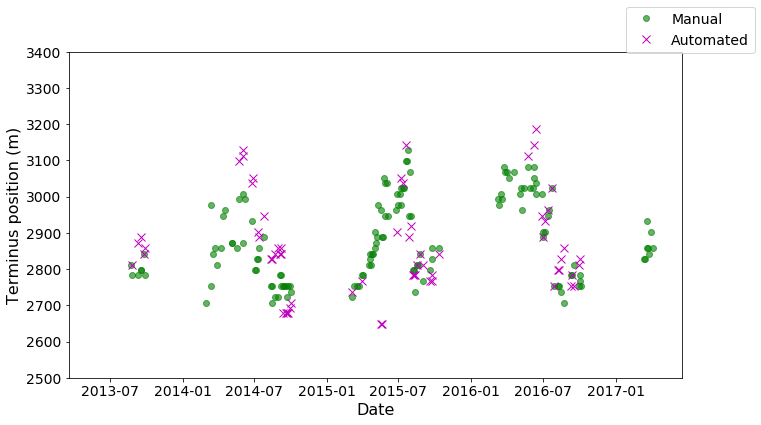

In [1011]:
fig, ax1 = plt.subplots(figsize=(11,6))
#MANUAL
# ax1.plot(ls8_df['datetimes'], np.array(ls8_df['term_position']) - max_tpos_man, 'go', markersize='5', alpha=0.6)
ax1.plot(ls8_df['datetimes'],np.array(ls8_df['tpos50']), 'go', markersize='6', alpha=0.6)
ax1.set_ylabel('Terminus position (m)', color='k', fontsize=16)

#AUTOMATED
offset_px = -7

# ax1.plot(auto_df['datetimes'], np.array(auto_df['tpos'])- max_Y, 'mx', markersize='10', alpha=1)
ax1.plot(auto_df['datetimes'], np.array(auto_df['tpos'])+offset_px*15, 'mx', markersize='8', alpha=1)
# ax2.set_ylabel('Auto terminus position (m)', color = 'k', fontsize=12)
# ax2.get_yaxis().set_visible(False) 

#GENERAL PLOT PARAMETERS
# ax1.set_title("Box"+BOI, fontsize=16)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylim(2500, 3400)
ax1.tick_params(axis='both', which='major', labelsize=14)
# fig.legend(['Manual', 'Automated'], bbox_to_anchor=(0.6,0.2), bbox_transform=ax1.transAxes, fontsize=14)
fig.legend(['Manual', 'Automated'], fontsize=14)

#SAVE FIGURE
# plt.title("Box"+BOI)
# plt.grid()
plt.savefig("/media/jukes/jukes1/Manual/Manual_vs_automated_Box"+BOI+".png", dpi=500)
plt.show()

In [995]:
comparison_df = pd.merge(auto_df.drop(['BoxID', 'changerate','Order'], axis=1), ls8_df.drop(['Line_x', 'Line_y', 'BoxID'], axis=1), how='inner', on='datetimes')
comparison_df = comparison_df.dropna()

In [996]:
comparison_df

,Unnamed: 0,Scene,Image_array,Dat_filename,Trimmed_dat_filename,Scale,datetimes,Metric,tpos,X,intersect_x,intersect_y,tpos50,tpos25,tpos75
0,1,LC80350052013235LGN00,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2013-08-23,883.557510,375.0,"[141.0, 159.0]",140,159,360.0,210.0,465.0
1,2,LC80310052013239LGN00,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2013-08-27,1121.788931,390.0,"[142.0, 159.0]",140,159,360.0,180.0,435.0
2,3,LC80320052013246LGN00,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2013-09-03,342.488842,360.0,"[140.0, 159.0]",141,158,375.0,270.0,465.0
3,4,LC80330052013253LGN00,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_001.dat,terminus_trim_001.dat,1,2013-09-10,215.669940,330.0,"[138.0, 159.0]",139,158,345.0,195.0,450.0
4,6,LC80320052014073LGN00,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2014-03-14,496.406398,630.0,"[158.0, 161.0]",139,158,345.0,210.0,435.0
5,7,LC80350052014078LGN00,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2014-03-19,838.170870,585.0,"[155.0, 160.0]",141,159,375.0,225.0,450.0
6,8,LC80310052014082LGN00,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_001.dat,terminus_trim_001.dat,1,2014-03-23,282.991515,570.0,"[154.0, 160.0]",141,158,375.0,225.0,435.0
7,9,LC80340052014087LGN00,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2014-03-28,796.405220,540.0,"[152.0, 160.0]",141,158,375.0,210.0,435.0
8,10,LC80310052014098LGN00,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2014-04-08,910.581028,510.0,"[150.0, 160.0]",141,158,375.0,225.0,435.0
9,11,LC80340052014103LGN00,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,terminus_000.dat,terminus_trim_000.dat,0,2014-04-13,1076.418135,495.0,"[149.0, 160.0]",141,158,375.0,225.0,435.0


In [997]:
# #recalculate terminus position for either side
# comparison_df['term_position_x'] = np.array(comparison_df['term_position_x']) - max_tpos_auto
# comparison_df['term_position_y'] = np.array(comparison_df['term_position_y']) - max_tpos_man

In [998]:
comparison_df['auto_man_diff'] = np.array(comparison_df['tpos50']) - np.array(comparison_df['tpos']-350)
# comparison_df['auto_man_diff'] = np.array(comparison_df['term_position'])-350 - np.array(comparison_df['tpos50'])

In [999]:
differences = np.array(comparison_df.auto_man_diff)
print("Automated vs. manual delineations")
print(len(comparison_df))
print("Max difference: "+str(np.max(abs(differences)))+' meters')
print("Average difference: "+str(np.average(abs(differences)))+' meters')
print("Median difference: "+str(np.median(abs(differences)))+' meters')

Automated vs. manual delineations
95
Max difference: 395.0 meters
Average difference: 276.1578947368421 meters
Median difference: 320.0 meters
